INCLUDED:
- single sample Gene set enrichment (ssGSEA) as semantics 
- samples + change in ssGSEA
- samples + gene expr change + ssGSEA


In [1]:
from aerial_plus_folder import aerial_plus
from aerial import model, rule_extraction, rule_quality
import thesis_functions as tf
import pandas as pd
import numpy as np
import time
import random

In [2]:
# Load expression data
expr_matrix_raw = pd.read_csv('Data/gene_expr_matrix_VLCD_LCD_2timepoints.csv', index_col=0) 
metadata = pd.read_csv('Data/metadata_filtered_2timepoints_VLCD_LCD.csv', index_col=0)
# Rename expr_matrix_raw columns using super_id from metadata
expr_matrix_raw.columns = metadata.loc[expr_matrix_raw.columns, 'super_id'].astype(str).values

# Subset only one treatment
super_ids_VLCD = metadata.loc[metadata['treatment'] == 'very-low-calorie diet', 'super_id']
expr_matrix_raw = expr_matrix_raw.loc[:, expr_matrix_raw.columns.isin(super_ids_VLCD)]
expr_matrix_raw.head()

# significant subset only
sig_genenames = pd.read_csv('Data/sig_genenames_VLCD_LCD.csv')
expr_matrix_raw_sig = expr_matrix_raw.loc[expr_matrix_raw.index.intersection(sig_genenames['x'])]
print(expr_matrix_raw_sig.shape) #250 genes, 50 samples

# Now load semantics
ssGSEA_matrix = pd.read_csv('ssGSEA_results_VLCD_LCD.csv', index_col=0)
subject_ids = ssGSEA_matrix.columns
# Replace columns with super IDs
ssGSEA_matrix.columns = metadata.loc[subject_ids, 'super_id'].values
# Transpose so subjects become rows
ssGSEA_matrix = ssGSEA_matrix.T
# Add original subject IDs as a new column
ssGSEA_matrix.insert(0, 'subject_id', subject_ids.values)
# Strip the prefix 'KEGG_' from all column names
ssGSEA_matrix.columns = [col.replace('KEGG_', '') for col in ssGSEA_matrix.columns]


(250, 50)


#### Now the semantics file is not necessary.  The ssGSEA file will be seen as the new semantics. However instead of semantics about genes it is actually values for subjects, so the columns can be easily appended

In [3]:
ssGSEA_matrix.head()
ssGSEA_matrix.shape #(101, 187)

# filter matrix for one treatment in case the two different treatments obscure patterns
ssGSEA_matrix_VLCD = ssGSEA_matrix.loc[ssGSEA_matrix.index.intersection(super_ids_VLCD)]
ssGSEA_matrix_VLCD.shape


(50, 187)

We also need to get a log fold change representation of this


In [27]:
GSEA_change_VLCD, metadata_change = tf.GetChangeDfs(ssGSEA_matrix_VLCD, metadata)
metadata_change.head() 
GSEA_change_VLCD.to_csv('GSEA_change_VLCD.csv')
GSEA_change_VLCD.head()

,ABC_TRANSPORTERS,ACUTE_MYELOID_LEUKEMIA,ADHERENS_JUNCTION,ADIPOCYTOKINE_SIGNALING_PATHWAY,ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,ALLOGRAFT_REJECTION,ALPHA_LINOLENIC_ACID_METABOLISM,ALZHEIMERS_DISEASE,AMINOACYL_TRNA_BIOSYNTHESIS,...,T_CELL_RECEPTOR_SIGNALING_PATHWAY,UBIQUITIN_MEDIATED_PROTEOLYSIS,VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS,VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,VASCULAR_SMOOTH_MUSCLE_CONTRACTION,VASOPRESSIN_REGULATED_WATER_REABSORPTION,VEGF_SIGNALING_PATHWAY,VIBRIO_CHOLERAE_INFECTION,VIRAL_MYOCARDITIS,WNT_SIGNALING_PATHWAY
subject_id,,,,,,,,,,,,,,,,,,,,,
1,0.01,0.01,0.01,0.00,0.01,0.03,0.03,-0.05,-0.02,-0.00,...,0.02,-0.00,0.02,-0.02,-0.01,0.01,0.01,0.03,0.02,0.00
2,0.00,0.02,0.01,0.00,-0.03,0.03,0.01,-0.04,-0.01,-0.01,...,0.03,-0.00,-0.01,-0.02,-0.00,-0.00,0.02,0.01,0.01,-0.00
3,-0.00,0.02,0.01,-0.00,-0.02,0.04,0.03,-0.05,-0.01,-0.02,...,0.03,-0.00,-0.03,-0.02,-0.01,-0.01,0.01,0.02,0.02,0.00
4,-0.01,-0.03,-0.02,-0.01,-0.02,-0.02,0.01,-0.03,0.02,0.01,...,-0.02,0.00,0.01,0.00,-0.03,-0.00,-0.03,-0.01,-0.01,-0.02
5,0.02,-0.00,0.00,0.01,0.02,0.04,0.07,-0.00,-0.01,0.04,...,0.01,0.03,0.06,0.06,-0.04,0.01,-0.01,0.04,0.02,-0.01


Similar to the genes,majority of pathways also dont change much 

0.13


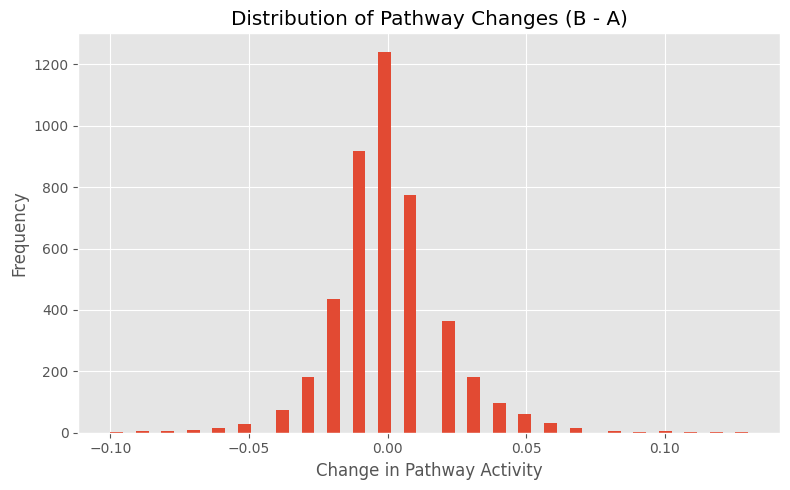

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style 


# Print the maximum change value across all pathways and subjects
print(GSEA_change_VLCD.max().max())

# Flatten all values into a 1D array and plot the distribution
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.hist(GSEA_change_VLCD.values.flatten(), bins=50)
plt.title('Distribution of Pathway Changes (B - A)')
plt.xlabel('Change in Pathway Activity')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The problem with discretization is:
- we dont want values that barely change to be part of a rule
- maybe if we do constraint based than we can make string labels and constraint the rules.
- not to a target class BUT to a target pattern. So if we put values like up, down, no change we can constrain the pattern to have one of these words in the consequent. 

In [ ]:
# Not sure if this is still relevant NO it is better to use a threshold for these values 


GSEA_change_VLCD_discr = tf.discretize_features_by_abs_threshold(GSEA_change_VLCD,threshold=0.02)
GSEA_change_VLCD_discr.to_csv('Data/GSEA_change_VLCD_discr_VLCD.csv', index=True)
GSEA_change_VLCD_discr = pd.read_csv('Data/GSEA_change_VLCD_discr_VLCD.csv', index_col=0)
GSEA_change_VLCD_discr.head()



,ABC_TRANSPORTERS,ACUTE_MYELOID_LEUKEMIA,ADHERENS_JUNCTION,ADIPOCYTOKINE_SIGNALING_PATHWAY,ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,ALLOGRAFT_REJECTION,ALPHA_LINOLENIC_ACID_METABOLISM,ALZHEIMERS_DISEASE,AMINOACYL_TRNA_BIOSYNTHESIS,...,T_CELL_RECEPTOR_SIGNALING_PATHWAY,UBIQUITIN_MEDIATED_PROTEOLYSIS,VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS,VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,VASCULAR_SMOOTH_MUSCLE_CONTRACTION,VASOPRESSIN_REGULATED_WATER_REABSORPTION,VEGF_SIGNALING_PATHWAY,VIBRIO_CHOLERAE_INFECTION,VIRAL_MYOCARDITIS,WNT_SIGNALING_PATHWAY
subject_id,,,,,,,,,,,,,,,,,,,,,
1,NoChange,NoChange,NoChange,NoChange,NoChange,Up,Up,Down,Down,NoChange,...,Up,NoChange,Up,Down,NoChange,NoChange,NoChange,Up,Up,NoChange
2,NoChange,Up,NoChange,NoChange,Down,Up,NoChange,Down,NoChange,NoChange,...,Up,NoChange,NoChange,Down,NoChange,NoChange,Up,NoChange,NoChange,NoChange
3,NoChange,Up,NoChange,NoChange,Down,Up,Up,Down,NoChange,Down,...,Up,NoChange,Down,Down,NoChange,NoChange,NoChange,Up,Up,NoChange
4,NoChange,Down,Down,NoChange,Down,Down,NoChange,Down,Up,NoChange,...,Down,NoChange,NoChange,NoChange,Down,NoChange,Down,NoChange,NoChange,Down
5,Up,NoChange,NoChange,NoChange,Up,Up,Up,NoChange,NoChange,Up,...,NoChange,Up,Up,Up,Down,NoChange,NoChange,Up,Up,NoChange


In [7]:
metadata_change_discr = tf.discretize_features_minmax_bins(metadata_change, bins=4, global_minmax=False)
metadata_change_discr.head()

,age,height,change_weight,change_bmi,change_bodyfat
subject_id,,,,,
1,(44.5-50.5],(165.0-169.5],(-9.0--7.0],(-3.3--2.8],(-4.3--3.2]
2,(44.5-50.5],(153.9-165.0],(-9.7--9.0],(-4.6--3.3],(-4.3--3.2]
3,(50.5-59.2],(169.5-179.0],(-12.799999999999999--9.7],(-4.6--3.3],(-9.7--6.7]
4,(31.9-44.5],(153.9-165.0],(-7.0--4.1],(-2.5--1.4],(-3.2--1.3]
5,(50.5-59.2],(169.5-179.0],(-12.799999999999999--9.7],(-4.6--3.3],(-9.7--6.7]


### Ok so now im going to try and do three experiments
1) What do rules look like with only GSEA changes? 
2) What do rules look like with metadata included?
3) What does it look like when we constraint metadata to be in consequent (features of interest)
 

In [18]:
def printAerialAverages(ae_results, ae_rules):

    metrics_to_average = ['support', 'confidence', 'zhangs_metric', 'lift']
    ae_results_df = pd.DataFrame(ae_rules)
    print(ae_results_df[metrics_to_average].mean())
    print(f"avg nr of rules AE:{ae_results['Nr Rules'].mean()}")

def removeNonInformativeCols(transaction_df):
    # Remove columns from transaction_df where there is only 1 value (non-informative)
    constant_cols = transaction_df.columns[transaction_df.nunique(dropna=False) <= 1].tolist()
    if constant_cols:
        print("Dropped constant columns:", constant_cols)

    # Drop
    transaction_df_use = transaction_df.loc[:, transaction_df.nunique(dropna=False) > 1]
    print(f"nr of columns left:{len(transaction_df_use.columns)} ")

    return transaction_df_use


In [ ]:
# Question 1 
df = tf.randomly_downsize(GSEA_change_VLCD_discr, col_frac=1, row_frac=1.0)
print(df.shape)
results_GSEA_Ch_thresh, rules_GSEA_Ch_thresh = tf.RunPyAerialnTimes(transaction_df= df, ant_sim = 0.5, cons_sim=0.6, 
                                                                    filter_thresholds=False, n=3, features_of_interest_onehot=False, batch_size=5, discard_feature_value = 'NoChange' )
try:
    printAerialAverages(results_GSEA_Ch_thresh, rules_GSEA_Ch_thresh )
    print(rules_GSEA_Ch_thresh)
except:
    print('no rules')


(24, 186)
no rules


1b Answer: It finds the same number of rules. The rules look good on eye but the stats are not great. 

In [ ]:
# # Question 1b
# GSEA_change_VLCD_thresholded = tf.MakeOneHotDf(GSEA_change_VLCD, threshold=0.03)
# GSEA_change_VLCD_thresholded.head()  # ITS VERY SPARSE BUT OK
# rules_GSEA_Ch_thr, stats_GSEA_Ch_thr = tf.RunPyAerialnTimes(GSEA_change_VLCD_thresholded, ant_sim = 0.7, cons_sim=0.8, 
#                                                                     filter_thresholds=False, n=1, features_of_interest_onehot=True, batch_size=5)
# print(len(rules_GSEA_Ch_thr))
# print(rules_GSEA_Ch_thr[0:20])

Basically, below we see again that the data has way too little signal. If we filter for the most informative columns we get rules. They are however low support. 

In [ ]:
# Question 1b with smaller nr of columns
GSEA_change_VLCD_thresholded = tf.MakeOneHotDf(GSEA_change_VLCD, threshold=0.02)
# MAKE INPUT DIMS SMALLER
GSEA_change_VLCD_thresholded_sub = tf.select_top_signal_columns(GSEA_change_VLCD_thresholded, method='signal', col_frac=0.2)
print(GSEA_change_VLCD_thresholded_sub.shape)
results_GSEA_Ch_thr_sub, rules_GSEA_Ch_thr_sub =  tf.RunPyAerialnTimes(GSEA_change_VLCD_thresholded_sub, ant_sim=0.3, cons_sim=0.8, 
                                                                    filter_thresholds=True, n=5, features_of_interest_onehot=True, batch_size=8, n_epochs=10)
printAerialAverages(results_GSEA_Ch_thr_sub, rules_GSEA_Ch_thr_sub)
print(rules_GSEA_Ch_thr_sub)

(24, 74)
number of rules before filtering 2728
number of rules after filtering 3
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1      11.085398       3.0           0.963         0.35         0.625   

       avg Zhangs Metric  
Run 1              0.664  
number of rules before filtering 3962
number of rules after filtering 14
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1      11.085398       3.0           0.963         0.35         0.625   
Run 2       9.308724      14.0           0.945         0.38         0.917   

       avg Zhangs Metric  
Run 1              0.664  
Run 2              0.224  
number of rules before filtering 1913
number of rules after filtering 13
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1      11.085398       3.0           0.963         0.35         0.625   
Run 2       9.308724      14.0           0.945         0.38         0.917   
Run 3       9.030436

In [ ]:
# Now run the algorithm also on FP_growth


def runFPGrowth(transaction_df, target_consequents = None, target_antecedents= None ,min_sup =0.6, min_conf=0.8):
    """
    target_features should be provided as commasepareted strings inside{} , a set
    """
    from mlxtend.frequent_patterns import fpgrowth, association_rules

    metrics_list = ['confidence', 'support', 'zhangs_metric', 'lift']
    # Perform FP growth with filter and save metrics
    itemsets = fpgrowth(transaction_df, min_support=min_sup, use_colnames=True, max_len=3)
    if itemsets.empty:
        print("No frequent itemsets found with the given min_support.")
        fp_rules = pd.DataFrame()
    else:
        fp_rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf, return_metrics= metrics_list)
        print(f'fp rules number: {len(fp_rules)}')
        # filter rules with target features 
    if target_consequents is not None:
        fp_rules_filtered = fp_rules[
            fp_rules['consequents'].apply(lambda x: x.issubset(target_consequents))]
        fp_rules = fp_rules_filtered
        print(f'fp rules number after filtering for target consequents (complete overlap): {len(fp_rules_filtered)}')

    if target_antecedents is not None:
        fp_rules_filtered = fp_rules[
            fp_rules['antecedents'].apply(lambda x: x.issubset(target_antecedents))]
        fp_rules = fp_rules_filtered
        print(f'fp rules number after filtering for target antecedents (complete overlap): {len(fp_rules_filtered)}')

    print(f"FP rules : {fp_rules}")
    print(fp_rules.iloc[:,2:-1].mean())
    return(fp_rules)

fp_rules_GSEA_Ch_thr_sub = runFPGrowth(GSEA_change_VLCD_thresholded_sub, min_sup=0.3, min_conf=0.8)

fp rules number: 32
FP rules :                                           antecedents  \
0     (ALPHA_LINOLENIC_ACID_METABOLISM_downregulated)   
1                 (FOLATE_BIOSYNTHESIS_downregulated)   
2   (FOLATE_BIOSYNTHESIS_downregulated, ALPHA_LINO...   
3                  (PARKINSONS_DISEASE_downregulated)   
4                  (PARKINSONS_DISEASE_downregulated)   
5                  (PARKINSONS_DISEASE_downregulated)   
6   (PARKINSONS_DISEASE_downregulated, ALPHA_LINOL...   
7   (PARKINSONS_DISEASE_downregulated, BIOSYNTHESI...   
8                  (PARKINSONS_DISEASE_downregulated)   
9          (SYSTEMIC_LUPUS_ERYTHEMATOSUS_upregulated)   
10         (SYSTEMIC_LUPUS_ERYTHEMATOSUS_upregulated)   
11  (COMPLEMENT_AND_COAGULATION_CASCADES_upregulated)   
12                  (ALLOGRAFT_REJECTION_upregulated)   
13  (COMPLEMENT_AND_COAGULATION_CASCADES_upregulated)   
14                  (ALLOGRAFT_REJECTION_upregulated)   
15                             (LYSOSOME_upregulated)   


/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Now combine these results with gene expression data.

In [45]:
GSEA_change_VLCD_thresholded_sub.head()

,BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS_downregulated,ALPHA_LINOLENIC_ACID_METABOLISM_downregulated,FOLATE_BIOSYNTHESIS_downregulated,LIMONENE_AND_PINENE_DEGRADATION_downregulated,OTHER_GLYCAN_DEGRADATION_upregulated,GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES_upregulated,SYSTEMIC_LUPUS_ERYTHEMATOSUS_upregulated,COMPLEMENT_AND_COAGULATION_CASCADES_upregulated,PARKINSONS_DISEASE_downregulated,STEROID_BIOSYNTHESIS_upregulated,...,ASCORBATE_AND_ALDARATE_METABOLISM_downregulated,FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS_downregulated,FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS_upregulated,VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS_downregulated,GLYCOSAMINOGLYCAN_BIOSYNTHESIS_CHONDROITIN_SULFATE_downregulated,GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN_SULFATE_upregulated,ANTIGEN_PROCESSING_AND_PRESENTATION_upregulated,GLYCOSAMINOGLYCAN_DEGRADATION_downregulated,GLYCOSAMINOGLYCAN_DEGRADATION_upregulated,GLYCOSYLPHOSPHATIDYLINOSITOL_GPI_ANCHOR_BIOSYNTHESIS_downregulated
Subject,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,1,1
2,1,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,1,1,1,1,0,1,...,1,0,0,1,0,0,0,0,0,0
4,1,1,0,1,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
5,0,0,0,0,1,1,1,1,0,1,...,0,0,0,0,0,1,1,0,1,0


In [43]:
# Because we will be dealing with many columns, FP growth is probably the better choice here
# Lets take the most informative pathway changes df
GSEA_change_VLCD_thresholded_sub
print(GSEA_change_VLCD_thresholded_sub.shape)
# combine with gene expression dataset
logfc_df_VLCD =tf.GetFoldChangeDf(expr_matrix_raw_sig, subjects_as_rows=True)
onehot_df_VLCD = tf.MakeOneHotDf(logfc_df_VLCD, threshold=0.1)
print(onehot_df_VLCD.shape)

# join
combined = GSEA_change_VLCD_thresholded_sub.join(onehot_df_VLCD, on='Subject')
print(combined.shape)
combined.head()

(24, 74)
(24, 500)
(24, 574)


,BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS_downregulated,ALPHA_LINOLENIC_ACID_METABOLISM_downregulated,FOLATE_BIOSYNTHESIS_downregulated,LIMONENE_AND_PINENE_DEGRADATION_downregulated,OTHER_GLYCAN_DEGRADATION_upregulated,GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES_upregulated,SYSTEMIC_LUPUS_ERYTHEMATOSUS_upregulated,COMPLEMENT_AND_COAGULATION_CASCADES_upregulated,PARKINSONS_DISEASE_downregulated,STEROID_BIOSYNTHESIS_upregulated,...,TYROBP_downregulated,TYROBP_upregulated,VLDLR-AS1_downregulated,VLDLR-AS1_upregulated,VLDLR_downregulated,VLDLR_upregulated,VSIG4_downregulated,VSIG4_upregulated,XAGE-4_downregulated,XAGE-4_upregulated
Subject,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,1,0,0,1,1,0
2,1,1,0,0,1,0,1,0,0,0,...,0,1,1,0,1,0,0,0,1,0
3,1,1,0,1,1,1,1,1,0,1,...,0,1,1,0,1,0,0,1,1,0
4,1,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5,0,0,0,0,1,1,1,1,0,1,...,0,1,0,0,0,0,0,1,0,1


In [123]:
fp_results_combined_06 = runFPGrowth(combined, target_antecedents=set(onehot_df_VLCD.columns), target_consequents=set(GSEA_change_VLCD_thresholded_sub.columns), min_sup=0.6, min_conf= 0.8)

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


fp rules number: 21461
fp rules number after filtering for target consequents (complete overlap): 667
fp rules number after filtering for target antecedents (complete overlap): 664
FP rules :                                     antecedents  \
313                       (ALDOC_downregulated)   
315                         (SCD_downregulated)   
317                            (C6_upregulated)   
319                        (GYS2_downregulated)   
321                     (SLC14A2_downregulated)   
...                                         ...   
21417                        (TF_downregulated)   
21425  (TF_downregulated, SREBF1_downregulated)   
21440    (TF_downregulated, FASN_downregulated)   
21450     (TF_downregulated, SCD_downregulated)   
21453   (TF_downregulated, ALDOC_downregulated)   

                                             consequents  confidence  \
313    (BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS_downr...    0.952381   
315    (BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS_dow

In [110]:
kegg_df = pd.read_csv('Data/kegg_pathway_matrix_229.csv')
kegg_df = kegg_df.set_index('SYMBOL', drop=True)
kegg_df.head()

,hsa00010 (Glycolysis / Gluconeogenesis),hsa00030 (Pentose phosphate pathway),hsa00040 (Pentose and glucuronate interconversions),hsa00051 (Fructose and mannose metabolism),hsa00053 (Ascorbate and aldarate metabolism),hsa00061 (Fatty acid biosynthesis),hsa00062 (Fatty acid elongation),hsa00071 (Fatty acid degradation),hsa00100 (Steroid biosynthesis),hsa00120 (Primary bile acid biosynthesis),...,hsa05330 (Allograft rejection),hsa05332 (Graft-versus-host disease),hsa05340 (Primary immunodeficiency),hsa05410 (Hypertrophic cardiomyopathy),hsa05412 (Arrhythmogenic right ventricular cardiomyopathy),hsa05414 (Dilated cardiomyopathy),hsa05415 (Diabetic cardiomyopathy),hsa05416 (Viral myocarditis),hsa05417 (Lipid and atherosclerosis),hsa05418 (Fluid shear stress and atherosclerosis)
SYMBOL,,,,,,,,,,,,,,,,,,,,,
FADS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FASN,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SCD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TNFRSF25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOXL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Now filter for genes that are OUTSIDE of the pathway in the consequent 

# for rule in rules
# pathway = consequent minus the suffix _lastword (remove the underscore and suffix)
# genes = antecedents minus the suffix _lastword (remove the underscore and suffix)
# get set of genes that are part of the pathway in.
# for this look in kegg df columf to find the pathway. 
# The problem is that the format is different. in pathway its capslock with underscores denoting either blankspace or ' / '. In kegg_df the format is like this 
# kegg_df:  hsa00010 (Glycolysis / Gluconeogenesis)  pathway: GLYCOLYSYS_GLUCONEOGENESIS 
# check if the antecedents have overlap with the genes that belong to the pathway and filter out those rules  




In [111]:
import re

# Example format for rules
# rules = [(3377807, frozenset({'SLC15A3_upregulated', 'PLA2G7_upregulated'}), frozenset({'ALDOSTERONE_REGULATED_SODIUM_REABSORPTION_upregulated'}))]

def normalize_pathway_name(pathway_name):
    # Extract pathway name from parentheses example: 'hsa00010 (Glycolysis / Gluconeogenesis)' 
    match = re.search(r'\((.*?)\)', pathway_name)
    if match:
        pathway = match.group(1)
        pathway = pathway.upper()
        # Replace all types of dashes surrounded by 1 space on each side with underscores
        pathway = re.sub(r' (?P<dash>[-–—]) ', '_', pathway)
        # Replace all types of dashes with underscores
        pathway = re.sub(r'[-–—]', '_', pathway)  
        # Replace slashes (with optional spaces) with underscores
        pathway = re.sub(r'\s*/\s*', '_', pathway)
        # Replace all spaces with underscores
        pathway = re.sub(r'\s+', '_', pathway)
        return pathway
    return pathway_name.upper()

# Rename columns of KEGG DF 
kegg_df.columns = [normalize_pathway_name(col) for col in kegg_df.columns]

'ALPHA_LINOLENIC_ACID_METABOLISM' in kegg_df.columns
#GSEA_change_VLCD_thresholded_sub.columns
# SOMETHING STILL WRONG WITH THIS RENAMING!!! 

True

In [112]:
#print(kegg_df.columns)
# for col in kegg_df.columns:
#     print(f"Original: {col} -> Normalized: {normalize_pathway_name(col)}")

#normalize_pathway_name('hsa00592 (alpha-Linolenic acid metabolism)')

kegg_df.columns = [normalize_pathway_name(col) for col in kegg_df.columns]
print(kegg_df.columns)



Index(['GLYCOLYSIS_GLUCONEOGENESIS', 'PENTOSE_PHOSPHATE_PATHWAY',
       'PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS',
       'FRUCTOSE_AND_MANNOSE_METABOLISM', 'ASCORBATE_AND_ALDARATE_METABOLISM',
       'FATTY_ACID_BIOSYNTHESIS', 'FATTY_ACID_ELONGATION',
       'FATTY_ACID_DEGRADATION', 'STEROID_BIOSYNTHESIS',
       'PRIMARY_BILE_ACID_BIOSYNTHESIS',
       ...
       'ALLOGRAFT_REJECTION', 'GRAFT_VERSUS_HOST_DISEASE',
       'PRIMARY_IMMUNODEFICIENCY', 'HYPERTROPHIC_CARDIOMYOPATHY',
       'ARRHYTHMOGENIC_RIGHT_VENTRICULAR_CARDIOMYOPATHY',
       'DILATED_CARDIOMYOPATHY', 'DIABETIC_CARDIOMYOPATHY',
       'VIRAL_MYOCARDITIS', 'LIPID_AND_ATHEROSCLEROSIS',
       'FLUID_SHEAR_STRESS_AND_ATHEROSCLEROSIS'],
      dtype='object', length=237)


In [124]:
def filterObviousFPrules(fp_rules, kegg_df):

    filtered_rules = []

    for idx, rule in fp_rules.iterrows():
        antecedents = rule['antecedents']
        consequents = rule['consequents']

        # Remove suffixes like _upregulated
        genes_antecedent = {gene.rsplit('_', 1)[0] for gene in antecedents}

        # Normalize each pathway and collect all genes from the matching columns
        pathway_genes = set()
        for cons in consequents:
            pathway = cons.rsplit('_', 1)[0]
            if pathway in kegg_df.columns:
                genes = kegg_df.index[kegg_df[pathway] == 1].tolist()
                pathway_genes.update(genes)
                # there are couple of pathways that were not in the original kegg df but for demo purposes ok. (only 3)

        # If the combined pathway genes exist and there's NO overlap, keep the rule
        # this is ok because FP growth is exhaustive so all possible subsets rules are prsent
        if pathway_genes and genes_antecedent.isdisjoint(pathway_genes):
            filtered_rules.append(rule)

    return filtered_rules


filtered_rules06 = filterObviousFPrules(fp_results_combined_06, kegg_df)
len(filtered_rules06)


568

In [118]:
fp_results_combined07 = runFPGrowth(combined, target_antecedents=set(onehot_df_VLCD.columns), target_consequents=set(GSEA_change_VLCD_thresholded_sub.columns), min_sup=0.7, min_conf= 0.8)



fp rules number: 1769
fp rules number after filtering for target consequents (complete overlap): 87
fp rules number after filtering for target antecedents (complete overlap): 87
FP rules :                                       antecedents  \
70                          (ALDOC_downregulated)   
72                               (C6_upregulated)   
74                          (FADS2_downregulated)   
76                        (SLC14A2_downregulated)   
78                          (SLC27A2_upregulated)   
...                                           ...   
1713   (FADS1_downregulated, ALDOC_downregulated)   
1725                       (SREBF1_downregulated)   
1738    (SCD_downregulated, SREBF1_downregulated)   
1744   (FASN_downregulated, SREBF1_downregulated)   
1750  (ALDOC_downregulated, SREBF1_downregulated)   

                                            consequents  confidence   support  \
70    (BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS_downr...    0.952381  0.833333   
72    (BIOSY

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [125]:
filtered_rules07 = filterObviousFPrules(fp_results_combined07, kegg_df)
len(filtered_rules07)

64

In [126]:
import thesis_functions as tf
# apply parse fromzenset to the first two columns # Apply the function to both columns

filtered_rules07_df = pd.DataFrame(fp_results_combined07)
for col in filtered_rules07_df.columns[0:2]:
    filtered_rules07_df[col] = filtered_rules07_df[col].apply(tf.parse_frozenset)

filtered_rules07_df

TypeError: expected string or bytes-like object, got 'frozenset'